# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.6: Moving average

<div class="alert alert-danger">
    Dev note - I used the wrong definition for "moving average" when I created this. This notebook still has value, not sure where to put it though
   
</div>


### 1.6.1: Time Series moving average


For time series data, the expected value (mean) of the data has little predictive power. In short, you compute the mean over the timeline you compute for, but this doesn't account for any trend.

Further, the mean here is heavily biased depending on the timeframe you collect your data for. An increasing linear trend will have a lower mean for earlier times, and a higher mean for later times.

Moving averages account for these problems. They are easier to compute than OLS, or more complicated, models, but capture local trends in the data very well, while also incorporating larger global trends to a lighter degree (depending on your window size).

With a Simple Moving Average (SMA), you decide up front on a rolling window period. For instance, you may choose a 20 day rolling window. Then, for each time period $n$, you compute the SMA as:

$SMA_n = \frac{1}{k}\sum_{n-k}^{n}{X_k}$

Practically, this value doesn't exist when $k < n$, so those rows are generally not computed. Some people choose to compute $SMA_n$ with just the "up to $k$ rows available". A problem with this approach is that the $SMA$ value is very noisy for the first few values before "settling down".

As a helpful tip, when plotting or performing an OLS on moving averages, ensure you use the centrepoint of the period in your analysis or visualisation. That is, if you computed $SMA_{10}$ with a window of 5, then you plot that point at 8 (the centrepoint of the window). Note that $SMA_{10}$ uses values between 6 and 10 to compute the value.

A problem with SMA is that they can be very slow to incorporate sudden changes in the data. For instance, if you 
Exponential inputs new data faster, but may produce false positives. 

To address this problem, the Exponential Moving Average (EMA) more heavily weights new data than old data. This incorporates information faster:

${EMA}_n = \alpha{X_n} + (1-\alpha){EMA}_{n-1}$

Where $\alpha$ is a smoothing constant, sometimes given as $\frac{\beta}{1+k}$, where $\beta$ is just a different smoothing constant (usually 1 or 2) and $k$ is the period of the moving average (or in alternate forms, the lag). Given both are constants, we can replace with the simple $\alpha$.

The risk with EMA is that new data is incorporated often very heavily, leading to false signals for unusual events and sudden changes. Most heavy analysis will consider by the EMA and SMA, comparing them and coming up with a combined measure.

In [1]:
%run setup.ipy

#### Question

1. Do moving averages lead or lag the current price?

In [ ]:
# Solution / Answer: lag

#### Exercise

1. Compute the Simple Moving Average of a stock price for a $k$ value of 20. Investigate the pandas `rolling` function.
2. Compute the Exponential moving average using pandas. There is a `ewm` function available on a series.
3. Plot the two methods and examine how they change, and how quickly, with sudden swings in the data.

In [2]:
# Solutions

import pandas as pd
import quandl

prices = quandl.get("PERTH/SPASX200A_M")


In [3]:
prices['SMA'] = prices.rolling(20).mean().shift(-10)

In [4]:
prices.columns

Index(['Index OEM', 'SMA'], dtype='object')

In [9]:
prices['EMA'] = prices['Index OEM'].ewm(span=20).mean()

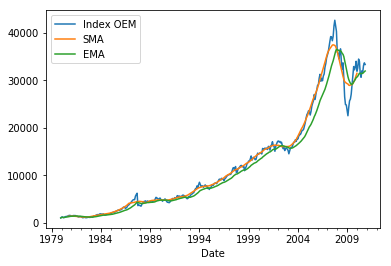

In [10]:
prices.plot()

#### Extended Exercise

A simple trading strategy is to compare the actual the moving average values, and take a position when they cross over. For instance, if the price crosses over from above, go short. If the price crosses over from below, go long.

Grab the stock prices for end of day from Quandl for a given stock (the solution uses Disney).

Find these crossover points, and compute the profit if you take these positions.

Hints:

* Create a column that indicates if the closing price is above or below the SMA
* What would you get if you ran the `diff` function on this data?
* For visualisation, checkout `plt.vlines` for drawing vertical lines (i.e. where the crossover exists)

In [11]:
# Solution
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

stocks = quandl.get("EOD/DIS")

In [13]:
stocks.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1962-01-02,37.25,38.50,37.25,37.25,2098.0,0.0,1.0,0.137931,0.142559,0.137931,0.137931,408858.24
1962-01-03,37.25,37.88,37.25,37.75,1998.0,0.0,1.0,0.137931,0.140264,0.137931,0.139782,389370.24
1962-01-04,37.75,37.88,37.50,37.75,2397.0,0.0,1.0,0.139782,0.140264,0.138857,0.139782,467127.36
1962-01-05,37.75,38.00,37.63,37.88,2397.0,0.0,1.0,0.139782,0.140708,0.139338,0.140264,467127.36
1962-01-08,37.88,38.38,37.00,37.75,3197.0,0.0,1.0,0.140264,0.142115,0.137005,0.139782,623031.36


In [42]:
n_periods = 200
stocks['SMA'] = stocks['Close'].rolling(n_periods).mean().shift(-int(n_periods/2))

In [43]:
stocks['Above_SMA'] = (stocks['Close'] > stocks['SMA']).astype('int')

In [44]:
# Compare this position to the previous, if different, this value is non-zero
stocks['PositionChange'] = stocks['Above_SMA'].diff()

In [45]:
# As you can see, PositionChange is -1 when we crossover from above, and 1 when we crossover from below
columns = ['Close', 'SMA', "Above_SMA", "PositionChange"]
stocks[columns].head(3)

,Close,SMA,Above_SMA,PositionChange
Date,,,,
1962-01-02,37.25,NaN,0,NaN
1962-01-03,37.75,NaN,0,0.0
1962-01-04,37.75,NaN,0,0.0


In [46]:
stocks[stocks['PositionChange'] == -1].index

DatetimeIndex(['1962-09-10', '1962-09-14', '1962-11-26', '1962-11-29',
               '1963-01-07', '1963-01-09', '1963-02-06', '1963-02-14',
               '1963-03-19', '1963-03-21',
               ...
               '2017-08-09', '2017-11-14', '2018-02-08', '2018-02-28',
               '2018-03-07', '2018-03-13', '2018-06-18', '2018-09-11',
               '2018-09-14', '2018-10-05'],
              dtype='datetime64[ns]', name='Date', length=468, freq=None)

(734869.0, 735963.0)

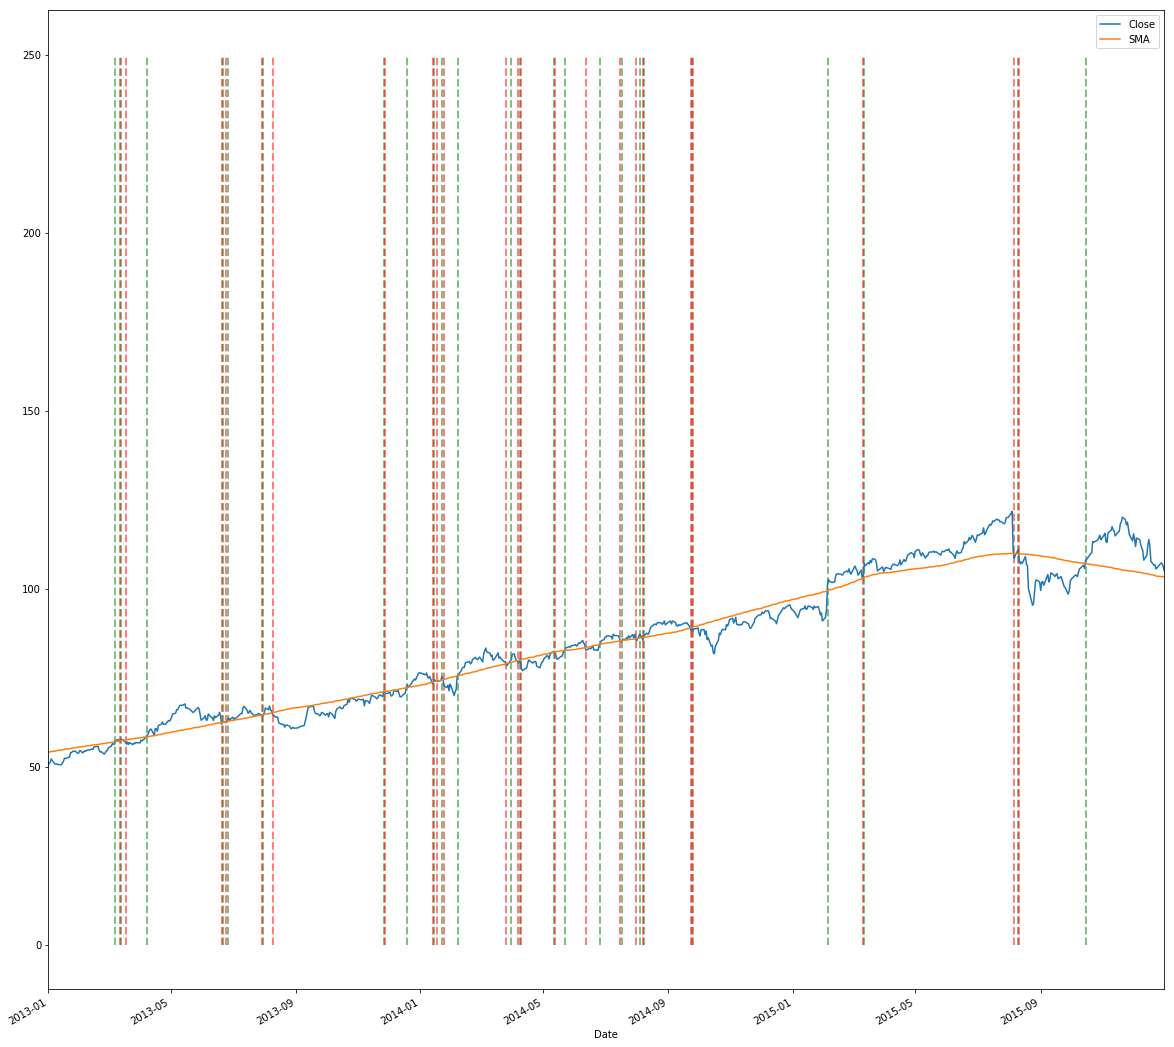

In [47]:
ax = stocks[['Close', 'SMA']].plot(figsize=(20, 20))
ax.vlines(stocks[stocks['PositionChange'] == 1].index, 0, 250,
           linestyles='dashed', colors='green', alpha=0.5, linewidths=2)
ax.vlines(stocks[stocks['PositionChange'] == -1].index, 0, 250,
           linestyles='dashed', colors='red', alpha=0.5, linewidths=2)

ax.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2015-12-31'))

### Other Usages

* **Long term versus Short term**:
    Another usage for the moving average is whether a short term MA (such as 15 days) is above or below the long term (say, 200 day) MA. This is similar to the exercise comparing the price itself to the SMA. If the short term MA crosses from below, it is considered an indicator of a bull market by some.

* **Above / Below Curve**: 
    Another simple indicator people use the SMA or EMA for is whether the current price is above or below the current moving average, rather than finding the point at which it crosses over. We end this module of an example of visualising this data, showing the periods where 

In [ ]:
import altair as alt
from vega_datasets import data

In [58]:
# Solution
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

stocks = quandl.get("EOD/DIS")
n_periods = 200
stocks['SMA'] = stocks['Close'].rolling(n_periods).mean().shift(-int(n_periods/2))

In [59]:
stocks.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,SMA
Date,,,,,,,,,,,,,
1962-01-02,37.25,38.50,37.25,37.25,2098.0,0.0,1.0,0.137931,0.142559,0.137931,0.137931,408858.24,NaN
1962-01-03,37.25,37.88,37.25,37.75,1998.0,0.0,1.0,0.137931,0.140264,0.137931,0.139782,389370.24,NaN
1962-01-04,37.75,37.88,37.50,37.75,2397.0,0.0,1.0,0.139782,0.140264,0.138857,0.139782,467127.36,NaN
1962-01-05,37.75,38.00,37.63,37.88,2397.0,0.0,1.0,0.139782,0.140708,0.139338,0.140264,467127.36,NaN
1962-01-08,37.88,38.38,37.00,37.75,3197.0,0.0,1.0,0.140264,0.142115,0.137005,0.139782,623031.36,NaN


In [60]:
stocks['Date'] = stocks.index

In [62]:
stocks['Gap'] = stocks['Close'] - stocks["SMA"]

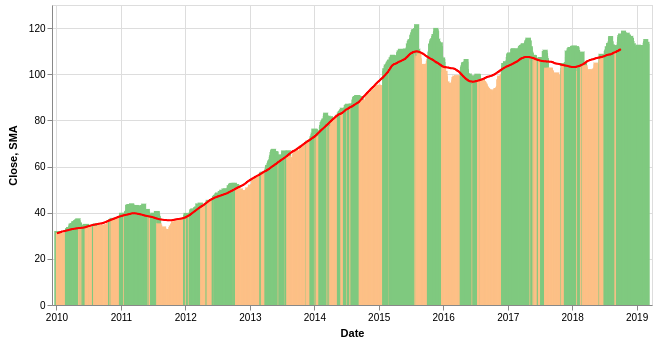

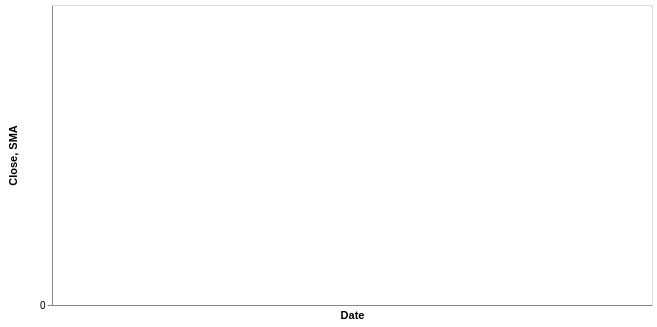

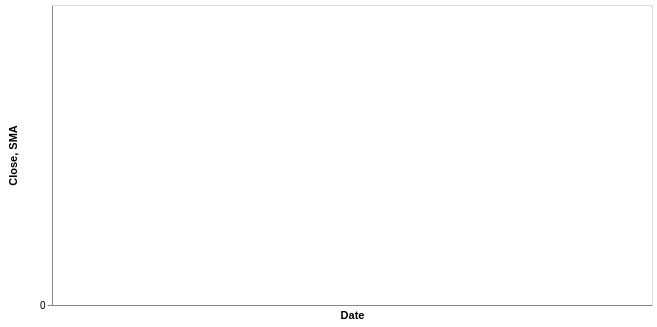

In [72]:
chart1 = alt.Chart(stocks["2010":]).mark_bar().encode(
    x="Date:T",
    y="Close:Q",
    color=alt.condition(
        alt.datum.Close > alt.datum.SMA,
        alt.value("#7fc97f"),  # The positive color
        alt.value("#fdc086")  # The negative color
    )
).properties(width=600)

chart2 = alt.Chart(stocks["2010":]).mark_line().encode(
    x="Date:T",
    y="SMA:Q",
    color=alt.value("red")
).properties(width=600)

chart1 + chart2